## Does the following:
-  Simulate data, store in RECOVAR format
- Load data and ground truth from file
- Attempt to solve with CG


In [7]:
import recovar.config
from importlib import reload
import numpy as np
from cryodrgn import analysis
from cryodrgn import utils
from cryodrgn import ctf
from recovar import plot_utils
from recovar import output, dataset
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from recovar import simulator
reload(simulator)
import jax
import warnings
# warnings.filterwarnings("error")

grid_size =256//1 *2
output_folder = f"/home/mg6942/mytigress/spike{grid_size}_ewald/"
volume_folder_input =  f"/home/mg6942/mytigress/spike{grid_size}/"
outlier_file_input = "/home/mg6942/mytigress/simulated_empiar10180/volumes/vol0915.mrc"
n_images = int(1e4)
voxel_size = 10 * 128 / grid_size#3/2/2
output.mkdir_safe(output_folder)
volume_distribution = np.zeros(1)
first_k = 1
volume_distribution[:first_k] = 1/first_k
image_stack, sim_info = simulator.generate_synthetic_dataset(output_folder, voxel_size, volume_folder_input, 
                                                             outlier_file_input, n_images, grid_size = grid_size,
                               volume_distribution = volume_distribution,  dataset_params_option = "dataset1", noise_level =1e-1, 
                               noise_model = "white", put_extra_particles = False, percent_outliers = 0.0, 
                               volume_radius = 0.6, trailing_zero_format_in_vol_name = True, noise_scale_std = 0.2 * 0, contrast_std =0.1 * 0 , disc_type = 'ewald_nearest')

(INFO) (ctf.py) (30-Dec-23 15:37:34) Image size (pix)  : 512
(INFO) (ctf.py) (30-Dec-23 15:37:34) A/pix             : 0.8187500238418579
(INFO) (ctf.py) (30-Dec-23 15:37:34) DefocusU (A)      : 15301.099609375
(INFO) (ctf.py) (30-Dec-23 15:37:34) DefocusV (A)      : 14916.400390625
(INFO) (ctf.py) (30-Dec-23 15:37:34) Dfang (deg)       : 5.28000020980835
(INFO) (ctf.py) (30-Dec-23 15:37:34) voltage (kV)      : 300.0
(INFO) (ctf.py) (30-Dec-23 15:37:34) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (30-Dec-23 15:37:34) w                 : 0.07000000029802322
(INFO) (ctf.py) (30-Dec-23 15:37:34) Phase shift (deg) : 0.0
(INFO) (simulator.py) (30-Dec-23 15:37:36) Batch 0: Generated 640 images so far
(INFO) (simulator.py) (30-Dec-23 15:37:37) Batch 1: Generated 1280 images so far
(INFO) (simulator.py) (30-Dec-23 15:37:39) Batch 2: Generated 1920 images so far
(INFO) (simulator.py) (30-Dec-23 15:37:41) Batch 3: Generated 2560 images so far
(INFO) (simulator.py) (30-Dec-23 15:37:42) B

(INFO) (ctf.py) (30-Dec-23 15:38:18) Image size (pix)  : 512
(INFO) (ctf.py) (30-Dec-23 15:38:18) A/pix             : 2.5
(INFO) (ctf.py) (30-Dec-23 15:38:18) DefocusU (A)      : 14115.7001953125
(INFO) (ctf.py) (30-Dec-23 15:38:18) DefocusV (A)      : 13773.400390625
(INFO) (ctf.py) (30-Dec-23 15:38:18) Dfang (deg)       : 7.800000190734863
(INFO) (ctf.py) (30-Dec-23 15:38:18) voltage (kV)      : 300.0
(INFO) (ctf.py) (30-Dec-23 15:38:18) cs (mm)           : 2.700000047683716
(INFO) (ctf.py) (30-Dec-23 15:38:18) w                 : 0.0
(INFO) (ctf.py) (30-Dec-23 15:38:18) Phase shift (deg) : 4.013987064361572
n images 10000


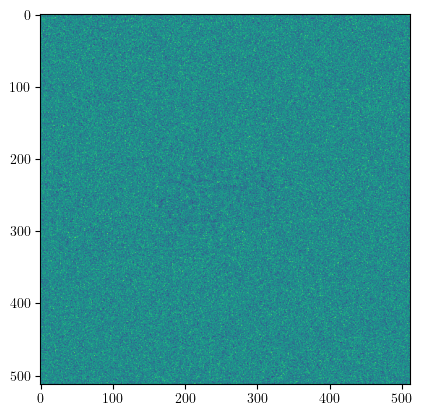

In [8]:
plt.imshow(image_stack[0])

grid_size =256*2
output_folder = f"/home/mg6942/mytigress/spike{grid_size}_ewald/"
# output_folder ='/home/mg6942/mytigress/spike256/../'
volume_folder_input =  f"/home/mg6942/mytigress/spike{grid_size}/"
outlier_file_input = "/home/mg6942/mytigress/simulated_empiar10180/volumes/vol0915.mrc"
dataset_dict = dataset.get_default_dataset_option()

# Fill these options with the path to preprocessed files
experiment_directory = '/home/mg6942/mytigress/uniform/'
dataset_dict['ctf_file'] = output_folder + "ctf.pkl"
dataset_dict['poses_file'] = output_folder + "poses.pkl"
dataset_dict['particles_file'] = f"{output_folder}particles.{grid_size}.mrcs"


# Returns an object that knows everything about the dataset.
cryo = dataset.load_dataset_from_dict(dataset_dict, lazy = False)
print("n images", cryo.n_images)
del dataset_dict['ind']

In [9]:
# cryo = dataset.load_cryodrgn_dataset( f"{output_folder}particles.{grid_size}.mrcs", output_folder + "poses.pkl", output_folder + "ctf.pkl", lazy = False)
from recovar import regularization, synthetic_dataset, noise, homogeneous, utils
sim_info = recovar.utils.pickle_load(output_folder + '/simulation_info.pkl')
gt_recon = synthetic_dataset.load_heterogeneous_reconstruction(sim_info, volumes_path_root = None)
gt_vol =gt_recon.get_mean()
noise_variance = sim_info['noise_variance']
signal_variance = utils.make_radial_image(regularization.average_over_shells(np.abs(gt_vol)**2, cryo.volume_shape), cryo.volume_shape)


In [14]:
from recovar import ewald
reload(ewald)
x, residuals = ewald.solve_ewald_least_squares(cryo, 100, "nearest", signal_variance, noise_variance)
plt.semilogy(residuals)

(INFO) (ewald.py) (30-Dec-23 15:45:56) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:05) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:09) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:13) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:17) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:21) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:25) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:29) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:33) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:36) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:40) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:44) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:48) batch size in second order: 100
(INFO) (ewald.py) (30-Dec-23 15:46:52) batch size in second order: 100
(INFO)